# TF isoform data


## TODO

- check valid clones only in all data
- get sequence information
- remove partners that didn't test positive with any isoform
- remove single isoforms
    - but need to add first to paralogs
- Look into effect of number of PPIs per TF
- combine categories to get paralog data

In [1]:
import os
from itertools import combinations

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd

import ccsblib
from ccsblib import ccsbplotlib as cplt

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones)

%matplotlib inline

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
y1h = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
isoforms = load_valid_isoform_clones()

In [3]:
iso_pairs = []
for tf_gene in isoforms['gene'].unique():
    tf_iso = isoforms.loc[isoforms['gene'] == tf_gene,
                          'clone_acc'].values
    for iso_a, iso_b in combinations(tf_iso, 2):
        iso_pairs.append((tf_gene, iso_a, iso_b))
iso_pairs = pd.DataFrame(data=iso_pairs,
                         columns=['tf_gene_symbol', 'clone_acc_a', 'clone_acc_b'])


def ppi_metric(row, data, function):
    gene_name = row['tf_gene_symbol']
    results = (data.loc[data['ad_gene_symbol'] == gene_name, :]
                   .pivot(values='score', index='db_gene_symbol', columns='ad_clone_acc'))
    ad_a = row['clone_acc_a']
    ad_b = row['clone_acc_b']
    if ad_a not in results.columns or ad_b not in results.columns:
        return np.nan
    pair = results.loc[:, [ad_a, ad_b]]
    # remove any partner with AA / NC / NS / NaN in either
    pair = pair.loc[pair.isin(['0', '1']).all(axis=1), :].astype(int).astype(bool)
    # remove partners that tested negative in both
    pair = pair.loc[pair.any(axis=1), :]
    if pair.shape[0] > 0:
        return function(set(pair.index[pair[ad_a]].values),
                        set(pair.index[pair[ad_b]].values))
    else:
        return np.nan

    
def jaccard_index(a, b):
    return len(a.intersection(b)) / len(a.union(b))


def simpsons_index(a, b):
    min_size =  min(len(a), len(b))
    if min_size == 0:
        return np.nan
    else:
        return len(a.intersection(b)) / min_size

    
def number_tested_partners(a, b):
    """Comes up with nan when it should be 0?"""
    return len(a.union(b))


def number_shared_partners(a, b):
    return len(a.intersection(b))


def number_min_partners(a, b):
    return min(len(a), len(b))


def min_difference(a, b):
    return min(len(a.difference(b)), len(b.difference(a)))


iso_pairs['ppi_n_tested'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=number_tested_partners,
                                            axis=1)
iso_pairs['ppi_n_shared'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=number_shared_partners,
                                            axis=1)
iso_pairs['ppi_n_min'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=number_min_partners,
                                            axis=1)
iso_pairs['ppi_n_min_diff'] = iso_pairs.apply(ppi_metric,
                                              data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                              function=min_difference,
                                              axis=1)
iso_pairs['ppi_jaccard'] = iso_pairs.apply(ppi_metric,
                                           data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                           function=jaccard_index,
                                           axis=1)
iso_pairs['ppi_simpsons'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=simpsons_index,
                                            axis=1)
iso_pairs['ppi_n_diff'] = iso_pairs['ppi_n_tested'] - iso_pairs['ppi_n_shared']


def fold_change_m1h(row):
    if (row['clone_acc_a'] not in m1h['clone_acc'].values or
        row['clone_acc_b'] not in m1h['clone_acc'].values):
        return np.nan
    a = m1h.loc[m1h['clone_acc'] == row['clone_acc_a'],
                [c for c in m1h.columns if c.startswith('M1H_rep')]].mean(axis=1).values[0]
    b = m1h.loc[m1h['clone_acc'] == row['clone_acc_b'],
                [c for c in m1h.columns if c.startswith('M1H_rep')]].mean(axis=1).values[0]
    return max(a, b) - min(a, b)


iso_pairs['activation_fold_change'] = iso_pairs.apply(fold_change_m1h, axis=1)

In [4]:
def pdi_metric(row, data, function):
    df = data.loc[(data['unique_acc'] == row['clone_acc_a']) |
                  (data['unique_acc'] == row['clone_acc_b']), 
                  data.columns[2:]].copy()
    if df.shape[0] < 2:
        return np.nan
    df = df.loc[:, df.any(axis=0)]
    if df.shape[1] == 0:
        return np.nan
    a = set(df.columns[df.iloc[0]])
    b = set(df.columns[df.iloc[1]])
    return function(a, b)


iso_pairs['pdi_n_tested'] = iso_pairs.apply(pdi_metric,
                                            data=y1h,
                                            function=number_tested_partners,
                                            axis=1)
iso_pairs['pdi_n_shared'] = iso_pairs.apply(pdi_metric,
                                            data=y1h,
                                            function=number_shared_partners,
                                            axis=1)
iso_pairs['pdi_n_min'] = iso_pairs.apply(pdi_metric,
                                            data=y1h,
                                            function=number_min_partners,
                                            axis=1)
iso_pairs['pdi_n_min_diff'] = iso_pairs.apply(pdi_metric,
                                              data=y1h,
                                              function=min_difference,
                                              axis=1)
iso_pairs['pdi_jaccard'] = iso_pairs.apply(pdi_metric,
                                           data=y1h,
                                           function=jaccard_index,
                                           axis=1)
iso_pairs['pdi_simpsons'] = iso_pairs.apply(pdi_metric,
                                            data=y1h,
                                            function=simpsons_index,
                                            axis=1)
iso_pairs['pdi_n_diff'] = iso_pairs['pdi_n_tested'] - iso_pairs['pdi_n_shared']

In [5]:
iso_pairs.head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpsons,ppi_n_diff,activation_fold_change,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpsons,pdi_n_diff
0,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535619,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,9.0,5.0,5.0,0.0,0.555556,1.0,4.0,2.094800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ARNT2,ARNT2|1/6|08C12,ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARNT2,ARNT2|2/6|09E01,ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


SpearmanrResult(correlation=-0.26507906812599813, pvalue=1.321168465578112e-05)

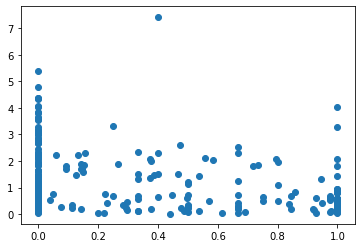

In [6]:
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
plt.scatter(xy[x], xy[y])
stats.spearmanr(xy[x], xy[y])

In [7]:
# Check if this result is robust against requiring at least
# one interaction partner for both genes.
# To see if the effect is driven by non-functional isoforms.
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() &
                   iso_pairs[y].notnull() &
                   (iso_pairs['ppi_n_min'] >= 1), :]
print(xy.shape)
stats.spearmanr(xy[x], xy[y])

(142, 18)


SpearmanrResult(correlation=-0.26863098874853214, pvalue=0.0012273703760291082)

(104, 18)


SpearmanrResult(correlation=-0.2500113196982098, pvalue=0.010479425843809722)

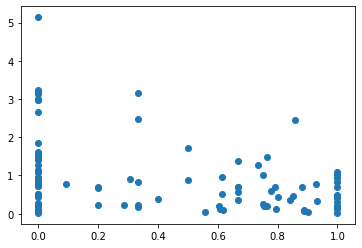

In [8]:
x = 'pdi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y])
stats.spearmanr(xy[x], xy[y])

(61, 18)


SpearmanrResult(correlation=0.24032405310412527, pvalue=0.06209683094347522)

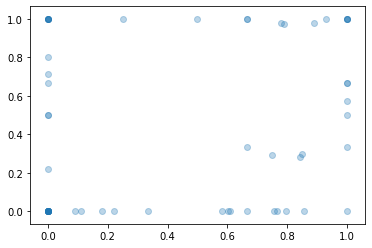

In [9]:
x = 'pdi_jaccard'
y = 'ppi_jaccard'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
stats.spearmanr(xy[x], xy[y])

In [10]:
xy.sort_values('activation_fold_change', ascending=False).head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpsons,ppi_n_diff,activation_fold_change,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpsons,pdi_n_diff
388,PPARG,PPARG|1/4|10G02,PPARG|3/4|01H02,4.0,0.0,0.0,0.0,0.0,NaN,4.0,3.180428,1.0,0.0,0.0,0.0,0.000000,NaN,1.0
484,TBX5,TBX5|1/3|08E01,TBX5|3/3|08H01,1.0,0.0,0.0,0.0,0.0,NaN,1.0,3.168219,12.0,4.0,4.0,0.0,0.333333,1.0,8.0
390,PPARG,PPARG|2/4|10F03,PPARG|3/4|01H02,5.0,0.0,0.0,0.0,0.0,NaN,5.0,2.969130,1.0,0.0,0.0,0.0,0.000000,NaN,1.0
48,E2F3,E2F3|2/4|10A08,E2F3|4/4|10G08,4.0,0.0,0.0,0.0,0.0,NaN,4.0,2.662217,1.0,0.0,0.0,0.0,0.000000,NaN,1.0
176,HNF4A,HNF4A|3/6|10C08,HNF4A|4/6|10A10,1.0,0.0,0.0,0.0,0.0,NaN,1.0,2.447053,7.0,6.0,6.0,0.0,0.857143,1.0,1.0


In [11]:
# Look at direction of activation change? I.e. is the isoform with less binding partners
# the one with activation closer to 0?

In [12]:
iso_pairs.sort_values('ppi_n_min_diff',
                      ascending=False).head(20)

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpsons,ppi_n_diff,activation_fold_change,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpsons,pdi_n_diff
644,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|4/9|10H06,15.0,5.0,9.0,4.0,0.333333,0.555556,10.0,1.324958,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354,PATZ1,PATZ1|1/4|02C02,PATZ1|3/4|02A04,18.0,12.0,15.0,3.0,0.666667,0.800000,6.0,1.239169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
513,TCF4,TCF4|5/9|07C02,TCF4|7/9|07G03,58.0,46.0,49.0,3.0,0.793103,0.938776,12.0,2.090708,NaN,NaN,NaN,NaN,NaN,NaN,NaN
645,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|5/9|10H05,15.0,6.0,9.0,3.0,0.400000,0.666667,9.0,1.493713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
811,ZNF451,ZNF451|6/8|05H11,ZNF451|7/8|06D01,8.0,1.0,4.0,3.0,0.125000,0.250000,7.0,1.485041,NaN,NaN,NaN,NaN,NaN,NaN,NaN
587,TFEC,TFEC|2/6|04A02,TFEC|5/6|04A01,5.0,0.0,2.0,2.0,0.000000,0.000000,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
514,TCF4,TCF4|5/9|07C02,TCF4|8/9|07A05,46.0,33.0,35.0,2.0,0.717391,0.942857,13.0,1.825006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|3/9|10B06,15.0,7.0,9.0,2.0,0.466667,0.777778,8.0,1.525376,NaN,NaN,NaN,NaN,NaN,NaN,NaN
655,ZBTB44,ZBTB44|3/9|10B06,ZBTB44|6/9|12H02,13.0,9.0,11.0,2.0,0.692308,0.818182,4.0,0.080167,NaN,NaN,NaN,NaN,NaN,NaN,NaN
801,ZNF451,ZNF451|3/8|06A03,ZNF451|6/8|05H11,7.0,1.0,3.0,2.0,0.142857,0.333333,6.0,0.201770,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
y2h.loc[y2h['category'] == 'tf_isoform_ppis', 'ad_gene_symbol'].nunique()

164

In [14]:
# Plot degree of binding partners vs. fraction of isoforms interacting

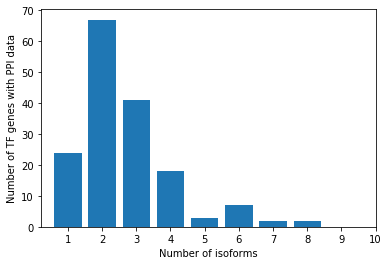

In [15]:
#    - Number of isoforms per TF gene

# remove isoform counts of 1?
n_iso = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').nunique()['ad_clone_acc']
fig, ax = plt.subplots(1, 1)
ax.bar(n_iso.value_counts().index,
       n_iso.value_counts().values)
ax.set_xticks(range(1, 11))
ax.set_xlabel('Number of isoforms')
ax.set_ylabel('Number of TF genes with PPI data');

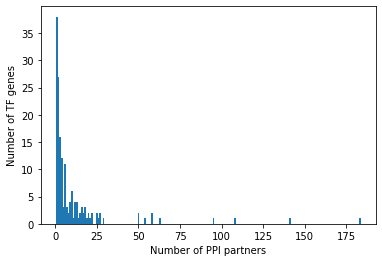

In [16]:
#    - Number of partners per TF gene

n_ppi = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes');

In [17]:
#    - How many isoforms have 0 interactions?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'ad_clone_acc'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'ad_clone_acc'].nunique()
print('Of {} isoforms, {} have at least one positive interation'.format(a, b))

Of 440 isoforms, 242 have at least one positive interation


In [18]:
#    - How many partners were negative in all pairwise tests?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].nunique()
print('Of {} tested partners, {} had at least one positive result'.format(a, b))

Of 914 tested partners, 728 had at least one positive result


In [19]:
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].unique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].unique()
c = set(a).difference(set(b))

In [20]:
# remove these interactions where none of the isoforms are 
y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
        y2h['db_gene_symbol'].isin(c), :].head()

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score
57,tf_isoform_ppis,101216,GATA1|1/2|08A02,GATA1,1579,TEKT4,0
103,tf_isoform_ppis,100301,SMAD3|1/4|06A07,SMAD3,1579,TEKT4,0
115,tf_isoform_ppis,100697,SMAD3|4/4|06F07,SMAD3,1579,TEKT4,0
126,tf_isoform_ppis,100657,SMAD3|2/4|06G07,SMAD3,1579,TEKT4,0
138,tf_isoform_ppis,100479,SMAD3|3/4|06B08,SMAD3,1579,TEKT4,0


In [21]:
def isoform_display_name(s):
       """Convert clone accession ID to display friendly format"""
       return s.split('|')[0] + '-' + s.split('|')[1].split('/')[0]

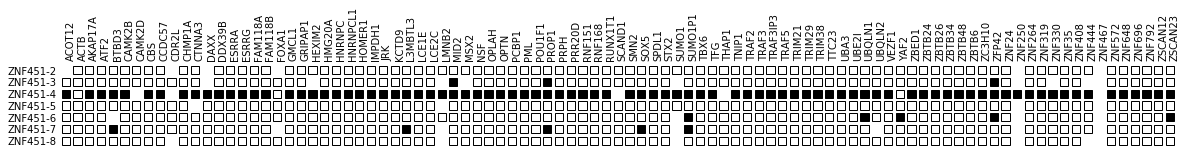

In [22]:
def y2h_ppi_per_tf_gene_plot(gene_name, 
                             data,
                             ax=None, 
                             min_n_isoforms=1,
                             min_n_partners=1):
    tf = data.loc[(data['category'] == 'tf_isoform_ppis') &
                (data['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf['ad_clone_acc'] = tf['ad_clone_acc'].apply(isoform_display_name)
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='score')
    if ax is None:
        ax = plt.gca()
    if tf.shape[0] < min_n_isoforms or tf.shape[1] < min_n_partners:
        ax.set_axis_off()
        ax.text(0.5, 0.5,
                'No PPI data available',
                ha='center', va='center',
                fontsize=30,
                fontweight='bold',
                color='grey')
        return
    cplt.binary_profile_matrix(tf, ax=ax, column_label_rotation=90)
    
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
gene_name = 'ZNF451'
y2h_ppi_per_tf_gene_plot(gene_name, data=y2h)

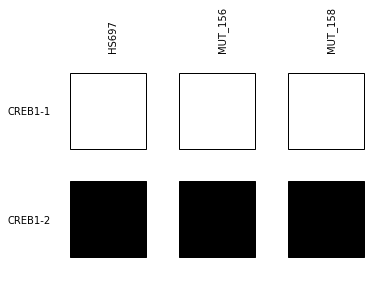

In [23]:
def y1h_pdi_per_tf_gene_plot(gene_name, 
                             data,
                             ax=None,
                             min_n_isoforms=1,
                             min_n_partners=1):
    tf = data.loc[data['tf'] == gene_name,
                  data.columns[1:]].copy().set_index('unique_acc')
    tf.index = tf.index.map(isoform_display_name)
    tf = tf.loc[:, tf.any(axis=0)]
    if ax is None:
        ax = plt.gca()
    if tf.shape[0] < min_n_isoforms or tf.shape[1] < min_n_partners:
        ax.set_axis_off()
        ax.text(0.5, 0.5,
                'No PDI data available',
                ha='center', va='center',
                fontsize=30,
                fontweight='bold',
                color='grey')
        return
    cplt.binary_profile_matrix(tf, ax=ax, column_label_rotation=90)


y1h_pdi_per_tf_gene_plot('CREB1', y1h)

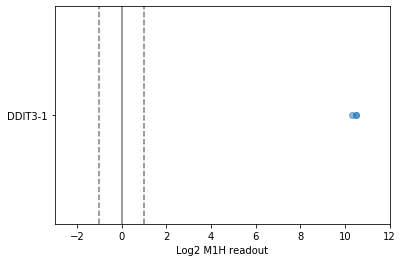

In [24]:
def m1h_activation_per_tf_gene_plot(tf_gene_name, data, ax=None):
    if ax is None:
        ax = plt.gca()
    if tf_gene_name not in data['gene'].values:
        ax.set_axis_off()
        ax.text(0.5, 0.5,
                'No activation data available',
                ha='center', va='center',
                fontsize=30,
                fontweight='bold',
                color='grey')
        return
    rep_columns = [c for c in data.columns if c.startswith('M1H_rep')]
    ax.scatter(
        y=[isoform_display_name(acc) for acc in data.loc[data['gene'] == tf_gene_name, 'clone_acc'].values
           for __ in range(len(rep_columns))],
        x=data.loc[data['gene'] == tf_gene_name, rep_columns].values.flatten(),
        alpha=0.5
        )
    ax.set_xlim(-3, 12)
    ax.set_xlabel('Log2 M1H readout')
    ax.axvline(0, linestyle='-', color='grey')
    ax.axvline(-1, linestyle='--', color='grey')
    ax.axvline(1, linestyle='--', color='grey')
    ax.invert_yaxis()
    
    
m1h_activation_per_tf_gene_plot('DDIT3', data=m1h)

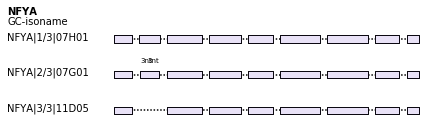

In [49]:
from isomodules import isocreate, isoimage, isofunc


def isoform_box_and_line_drawing(gene_name, ax=None):
    if ax is None:
        ax = plt.gca()
    path_6k_gtf = 'data/hTFIso6K_valid_isoforms/c_6k_unique_acc_aligns.gtf'
    path_6k_fa = 'data/hTFIso6K_valid_isoforms/j2_6k_unique_isoacc_and_nt_seqs.fa'
    orf_seqs_6k = isofunc.oc_fasta_to_orf_seq_dict(path_6k_fa)
    gd = isocreate.init_gen_obj(path_6k_gtf, [gene_name])
    gd = isocreate.create_and_link_seq_related_obj(gd, orf_seqs_6k)
    isoimage.render_iso_image(list(gd[gene_name].orfs), ax=ax)


isoform_box_and_line_drawing('NFYA')

AttributeError: 'CDS' object has no attribute 'start_subtle_splice'

<Figure size 432x288 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

<Figure size 504x1440 with 0 Axes>

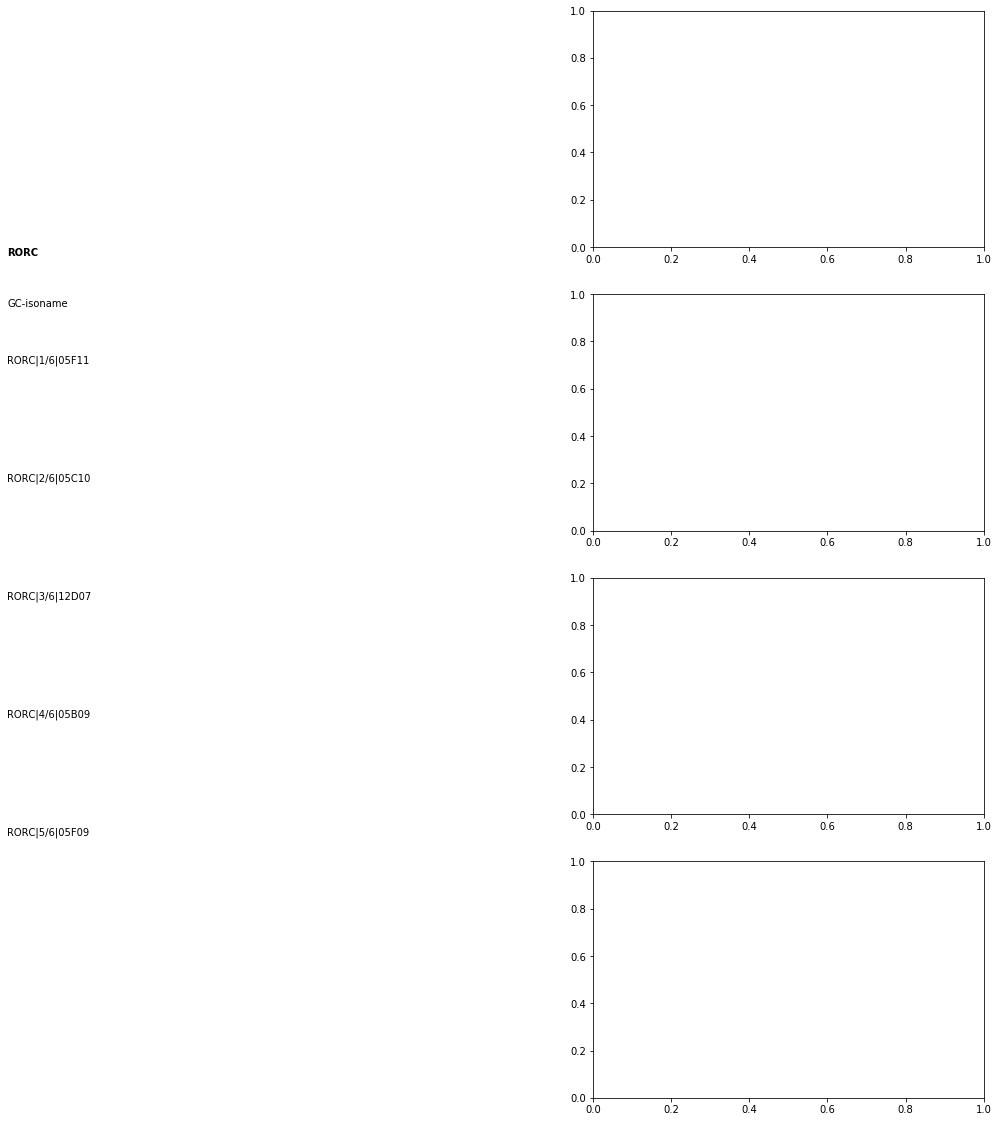

In [52]:

#  - show sequences
def tf_gene_summary_plot(gene_name):
    """
    - show sequences
    - add missing data to Y1H and M1H so that the number of isoforms lines up between each plot

    """
    plt.clf()
    n_iso_y2h = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['ad_gene_symbol'] == gene_name),
                        'ad_clone_acc'].nunique()
    n_partner_y2h = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                            (y2h['ad_gene_symbol'] == gene_name),
                            'db_gene_symbol'].nunique()
    n_iso_y1h = (y1h['tf'] == gene_name).sum()
    n_partner_y1h = y1h.loc[(y1h['tf'] == gene_name), y1h.columns[2:]].any(axis=0).sum()
    fig, axes = plt.subplots(4, 1)
    fig.set_size_inches(max(7, n_partner_y2h * 0.2, n_partner_y2h * 0.2),
                        max(20, n_iso_y2h * 0.2, n_iso_y1h * 0.2))
    
    isoform_box_and_line_drawing(gene_name, ax=axes[0])
    y2h_ppi_per_tf_gene_plot(gene_name, data=y2h, ax=axes[1])
    y1h_pdi_per_tf_gene_plot(gene_name, data=y1h, ax=axes[2])
    m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=axes[3])
    os.makedirs('figures/per_tf_gene', exist_ok=True)
    plt.savefig('figures/per_tf_gene/' + gene_name + '_summary.pdf',
                bbox_inches='tight')


all_genes = set(y2h['ad_gene_symbol'].unique()).union(set(y1h['tf'].unique())).union(set(m1h['gene'].unique()))
for gene in all_genes:
    tf_gene_summary_plot(gene)